In [37]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from math import ceil
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
import time
from sklearn.model_selection import KFold
import seaborn as sns
# from sklearn.model_selection import train_test_split

In [38]:

# # !pip install pandas numpy matplotlib plotly scikit-learn seaborn
# !pip install mord 
# !pip uninstall jupyter jupyterlab -y
# !pip uninstall ipykernel -y
# !pip install ipykernel
# !python -m ipykernel install --user --name .F1_venv --display-name "F1_venv"
# !pip install numpy pandas matplotlib seaborn plotly scikit-learn scipy xgboost lightgbm pyswarms scikit-optimize mord


# LOAD AND PREPARE DATA

Test Dataset 1

In [39]:
# # Load and clean data
# data = pd.read_csv("traffic_crashes_people.csv")
# data = data.drop(['physical_condition', 'airbag_deployed', 'ejection'], axis=1)
# # Random sample 8,000 rows using seed 1337
# data = data.dropna().reset_index(drop=True)
# data = data.sample(n=25000, random_state=1337)
# target = 'injury_classification'
# data.head()

Test Dataset 2

In [40]:
# # Cleanning Method 2 ================================
# data = pd.read_table('fruit_data_with_colors.txt')
# data = data.dropna().drop(columns=['fruit_subtype', 'fruit_label'])
# target = "fruit_name"
# data.head()


Test Dataset 3

In [41]:
# Load and clean data
data_raw = pd.read_csv("F1_main_data_v9.csv")
data = data_raw.copy()
# data = data.drop(['physical_condition', 'airbag_deployed', 'ejection'], axis=1)
# Random sample 8,000 rows using seed 1337
# data = data.dropna().reset_index(drop=True)
# data = data.sample(n=25000, random_state=1337)
# data=data.drop(columns=["Timestamp","driver_code","GrandPrix","team","Consistency_Race", "Style_Race",
#                         "Technical_Race","Pace_Race","PerformanceIndex_Race"])
data=data.drop(columns=["Timestamp","driver_code","GrandPrix","Consistency_Race", "Style_Race",
                        "Technical_Race","Pace_Race","PerformanceIndex_Race","driver_points","team_points"])
target = 'RaceFinishPosition'
# print(data.head())
print(data.head())

   Consistency_Qual  Style_Qual  Technical_Qual  Pace_Qual  \
0          0.254063    0.202593        0.403174       0.80   
1          0.000000    0.199975        0.305004       0.75   
2          0.168950    0.500000        0.417430       0.90   
3          0.340871    0.202912        0.190251       0.95   
4          0.463925    0.792030        0.231651       0.85   

   PerformanceIndex_Qual  Round  year  QualifyingPosition  RaceFinishPosition  \
0               0.414957     12  2025                   5                 4.0   
1               0.313745     12  2025                   6                14.0   
2               0.496595     12  2025                   3                 1.0   
3               0.421008     12  2025                   2                 2.0   
4               0.584402     12  2025                   4                10.0   

       team  ...  Finish_pct  Accident_pct  Collision_pct  Damage Related_pct  \
0   Ferrari  ...   84.415584      3.896104      11.688312  

In [42]:
data.shape

(726, 30)

# PROCESS DATA

MODIFIED Race Finish Position as Ordinal Values

In [43]:
# # METHOD 1 What Position ==========================================
# # Converting Race Finish Output to Integer Values
# # data2.loc[:, "RaceFinishPosition"] = data2["RaceFinishPosition"].astype(int)
# data["RaceFinishPosition"] = pd.to_numeric(data["RaceFinishPosition"], errors="coerce").fillna(0).astype(int)


# # METHOD 2 Podium vs No Podium ==========================================
# # Convert to numeric safely
# data["RaceFinishPosition"] = pd.to_numeric(data["RaceFinishPosition"], errors="coerce")

# # Classify: 1 if Podium (positions 1, 2, 3), 0 otherwise
# data["RaceFinishPosition"] = np.where(data["RaceFinishPosition"].between(1, 3), 1, 0)

# # METHOD 3 1st place or None ==========================================
# # Convert to numeric safely
# data["RaceFinishPosition"] = pd.to_numeric(data["RaceFinishPosition"], errors="coerce")

# # Classify: 1 if Podium (positions 1, 2, 3), 0 otherwise
# data["RaceFinishPosition"] = np.where(data["RaceFinishPosition"].between(1, 1), 1, 0)

# data["RaceFinishPosition"].head()

# METHOD 4. 4 Categories. 1st 2nd 3rd and No Podium =========================
# Convert to numeric safely
data["RaceFinishPosition"] = pd.to_numeric(data["RaceFinishPosition"], errors="coerce")

# 4 categories: 1st, 2nd, 3rd, no podium (0)
data["RaceFinishPosition"] = np.select(
    [
        data["RaceFinishPosition"] == 1,
        data["RaceFinishPosition"] == 2,
        data["RaceFinishPosition"] == 3,
    ],
    [1, 2, 3],
    default=0
)

print(data["RaceFinishPosition"].head())

0    0
1    0
2    1
3    2
4    0
Name: RaceFinishPosition, dtype: int64


Check Numerical and Categorical Columns  

In [44]:
# Identify categorical and numeric columns
cat_cols = data.select_dtypes(include=['object', 'category']).columns
num_cols = data.select_dtypes(exclude=['object', 'category']).columns

print("Numeric columns:", num_cols.tolist())
print("Categorical columns:", cat_cols.tolist())

# --- Check for missing values ---
missing_info = data.isna().sum()  # count NaN per column
missing_info = missing_info[missing_info > 0]  # only show columns with NaN

if not missing_info.empty:
    print("\n🧩 Columns with missing values:")
    print(missing_info.sort_values(ascending=False))
else:
    print("\n✅ No missing values found in the dataset!")

# Fill all numeric columns with their mean
data[num_cols] = data[num_cols].apply(lambda x: x.fillna(x.mean()))

# (Optional) For categorical columns, you can fill NaN with a placeholder
data[cat_cols] = data[cat_cols].fillna("Unknown")

# Verify if any NaN remain
print("\nRemaining missing values after mean imputation:")
print(data.isna().sum()[data.isna().sum() > 0])



Numeric columns: ['Consistency_Qual', 'Style_Qual', 'Technical_Qual', 'Pace_Qual', 'PerformanceIndex_Qual', 'Round', 'year', 'QualifyingPosition', 'RaceFinishPosition', 'Laps', 'Corners', 'Circuit length (km)', 'Race distance (km)', 'Accident', 'Collision', 'Damage Related', 'Finish', 'Total_Entries', 'Finish_pct', 'Accident_pct', 'Collision_pct', 'Damage Related_pct', 'DNF_pct', 'Race_Complexity_Score', 'Safety_Index', 'mechanical_faults', 'avg_stops_per_car_race', 'avg_pitstop_ms']
Categorical columns: ['team', 'Direction']

🧩 Columns with missing values:
PerformanceIndex_Qual    2
Consistency_Qual         1
Style_Qual               1
dtype: int64

Remaining missing values after mean imputation:
Series([], dtype: int64)


One Hot Encoding

In [45]:
X = data.drop(columns=[target])
y = data[target]

# Separate categorical and numeric columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns
num_cols = X.select_dtypes(exclude=['object', 'category']).columns.tolist()

# Only build encoder if categorical columns exist
if len(cat_cols) > 0:
    ohe = OneHotEncoder(
        handle_unknown='infrequent_if_exist',
        min_frequency=0.01,   # ~1% threshold for infrequent categories
        sparse_output=False,
        dtype=int              # ensures 0/1 not True/False
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', ohe, cat_cols),
            ('num', 'passthrough', num_cols)
        ],
        remainder='drop'
    )

    # ⚠️ Use fit_transform only the first time
    X_encoded = preprocessor.fit_transform(X)
    feature_names = preprocessor.get_feature_names_out()
else:
    X_encoded = X.values
    feature_names = X.columns

data2 = pd.DataFrame(X_encoded, columns=feature_names)

# Attach target
data2 = pd.concat([data2, y.reset_index(drop=True)], axis=1)

print(data2.head())

   cat__team_Alpine Renault  cat__team_Aston Martin Aramco Mercedes  \
0                       0.0                                     0.0   
1                       0.0                                     0.0   
2                       0.0                                     0.0   
3                       0.0                                     0.0   
4                       0.0                                     0.0   

   cat__team_Ferrari  cat__team_McLaren  cat__team_McLaren Mercedes  \
0                1.0                0.0                         0.0   
1                1.0                0.0                         0.0   
2                0.0                1.0                         0.0   
3                0.0                1.0                         0.0   
4                0.0                0.0                         0.0   

   cat__team_McLaren Renault  cat__team_Mercedes  cat__team_Red Bull Racing  \
0                        0.0                 0.0                   

# SPLIT TRAIN, VAIDATION, TEST

### SELECT TEST DATA

METHOD 1  
Last rows as test data. Best for Time Series

In [46]:
# # Separate features and target
# X = data2.drop(columns=[target])
# y = data2[target]
# num_latest_data = int(len(X)*0.05)
# # Final test: last 1000 rows (keep deterministic)
# X_test = X.tail(num_latest_data)
# y_test = y.tail(num_latest_data)

# # Remaining data
# X_train_val = X.iloc[:-num_latest_data]
# y_train_val = y.iloc[:-num_latest_data]

# print(f"Train and Val size: {len(X_train_val)} rows ({len(X_train_val)/len(X)*100:.1f}%)")
# print(f"Test size: {len(X_test)} rows ({len(X_test)/len(X)*100:.1f}%)")


METHOD 2  
General Method

In [47]:
# X = data2.drop(columns=[target])
# y = data2[target]

# # --- Step 1: Split into Train (70%) and Temp (30%) ---
# X_train_val, X_test, y_train_val, y_test = train_test_split(
#     X, y,
#     test_size=0.05,           # 30% for val+test
#     random_state=42,         # reproducibility
#     stratify=None            # set to y if classification
# )

# print(f"Train and Val size: {len(X_train_val)} rows ({len(X_train_val)/len(X)*100:.1f}%)")
# print(f"Test size: {len(X_test)} rows ({len(X_test)/len(X)*100:.1f}%)")

METHOD 3  
Future Predicting 2025 Data

In [48]:
print(data2.head())

   cat__team_Alpine Renault  cat__team_Aston Martin Aramco Mercedes  \
0                       0.0                                     0.0   
1                       0.0                                     0.0   
2                       0.0                                     0.0   
3                       0.0                                     0.0   
4                       0.0                                     0.0   

   cat__team_Ferrari  cat__team_McLaren  cat__team_McLaren Mercedes  \
0                1.0                0.0                         0.0   
1                1.0                0.0                         0.0   
2                0.0                1.0                         0.0   
3                0.0                1.0                         0.0   
4                0.0                0.0                         0.0   

   cat__team_McLaren Renault  cat__team_Mercedes  cat__team_Red Bull Racing  \
0                        0.0                 0.0                   

In [49]:
# ✅ Split dataset by year
train_val_data = data2[data2["num__year"] < 2025].copy()    # all years before 2025
data_2025 = data2[data2["num__year"] == 2025].copy()        # only 2025 data

# --- Control what % of 2025 data to use for test ---
test_fraction = 0.99 # 👈 set this to the % (e.g., 0.3 = 30%, 0.5 = 50%)

data_2025_train, data_2025_test = train_test_split(
    data_2025,
    test_size=test_fraction,
    random_state=42,     # reproducibility
    shuffle=True         # shuffle so random subset of 2025 data
)

# Combine all training data (pre-2025 + part of 2025)
train_val_data = pd.concat([train_val_data, data_2025_train], ignore_index=True)
test_data = data_2025_test.copy()

# Define features and target
X_train_val = train_val_data.drop(columns=[target])
y_train_val = train_val_data[target]

X_test = test_data.drop(columns=[target])
y_test = test_data[target]

# --- Display summary ---
print(f"Training + Validation size: {len(X_train_val)} rows ({len(X_train_val)/len(data2)*100:.1f}%)")
print(f"Test size ({test_fraction*100:.0f}% of 2025 data): {len(X_test)} rows ({len(X_test)/len(data2)*100:.1f}%)")


Training + Validation size: 601 rows (82.8%)
Test size (99% of 2025 data): 125 rows (17.2%)


In [50]:
print(X_test.head())

     cat__team_Alpine Renault  cat__team_Aston Martin Aramco Mercedes  \
73                        0.0                                     0.0   
19                        0.0                                     0.0   
116                       0.0                                     0.0   
67                        0.0                                     0.0   
94                        0.0                                     0.0   

     cat__team_Ferrari  cat__team_McLaren  cat__team_McLaren Mercedes  \
73                 0.0                1.0                         0.0   
19                 0.0                0.0                         0.0   
116                0.0                0.0                         0.0   
67                 0.0                0.0                         0.0   
94                 0.0                1.0                         0.0   

     cat__team_McLaren Renault  cat__team_Mercedes  cat__team_Red Bull Racing  \
73                         0.0           

### SELECT VALIDATION DATA

METHOD 1  
General method with Sklearn

In [51]:
X = X_train_val.copy()
y = y_train_val.copy()

# --- Step 1: Split into Train (70%) and Temp (30%) ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.10,           # 30% for val+test
    random_state=42,         # reproducibility
    stratify=None            # set to y if classification
)

print(f"Train and Val size: {len(X_train)} rows ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test size: {len(X_val)} rows ({len(X_val)/len(X)*100:.1f}%)")

Train and Val size: 540 rows (89.9%)
Test size: 61 rows (10.1%)


### DATA SCALING

In [52]:
# # scaler = StandardScaler()
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)   # fit on TRAIN only
# X_val_scaled   = scaler.transform(X_val)         # transform VAL with same scaler
# X_test_scaled  = scaler.transform(X_test)     

### PROPORTIONAL CHANCE CRITERION

Population per class:     0
0  523
1   72
2   71
3   60
Proportion Chance Criterion: 54.52%
Model Accuracy to Beat: 68.15%


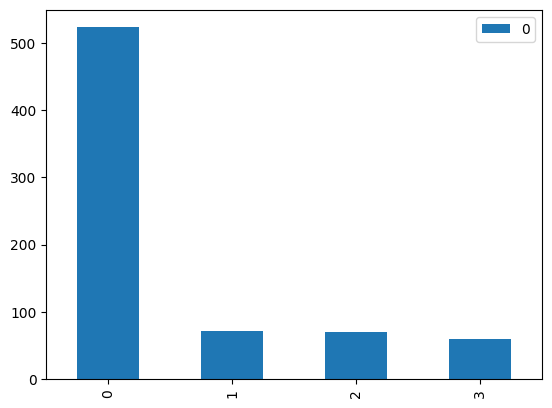

In [55]:
import numpy as np
from collections import Counter
state_counts = Counter(data[target])
df_state = pd.DataFrame.from_dict(state_counts, orient='index')
df_state.plot(kind='bar')

num=(df_state[0]/df_state[0].sum())**2

print("Population per class:{}".format(df_state))

print("Proportion Chance Criterion: {:0.2f}%".format(100*num.sum()))
print("Model Accuracy to Beat: {:0.2f}%".format(1.25*100*num.sum()))

# ML MODELLING

Default Settings. Single Run. No Hyperparameter Tuning

In [18]:
# --- imports ---
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.pipeline import make_pipeline
import pandas as pd

# NEW: import an ordinal classifier
# !pip install mord --quiet
import mord as m  # Mord implements ordinal logistic regression (LogisticIT, OrdinalRidge, etc.)

# --- define models (pipelines where scaling helps) ---
pipe_lr  = make_pipeline(MinMaxScaler(), LogisticRegression(max_iter=10000))
pipe_knn = make_pipeline(MinMaxScaler(), KNeighborsClassifier())
pipe_svm = make_pipeline(MinMaxScaler(), SVC())
pipe_nb  = make_pipeline(MinMaxScaler(), GaussianNB())

DT  = DecisionTreeClassifier()
RF  = RandomForestClassifier()
GBM = GradientBoostingClassifier()
LGB = LGBMClassifier(verbose=-1)

# NEW: Ordinal Logistic Regression model (LogisticIT)
ORD = make_pipeline(MinMaxScaler(), m.LogisticIT())  # cumulative link model

# --- XGBoost requires encoded y ---
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)
XGB = xgb.XGBClassifier(verbosity=0, eval_metric='mlogloss')

# --- fit on X_train/y_train ---
ORD.fit(X_train, y_train)
pipe_lr.fit(X_train, y_train)
pipe_knn.fit(X_train, y_train)
pipe_svm.fit(X_train, y_train)
pipe_nb.fit(X_train, y_train)

DT.fit(X_train, y_train)
RF.fit(X_train, y_train)
GBM.fit(X_train, y_train)
LGB.fit(X_train, y_train)
XGB.fit(X_train, y_train_enc)

# --- evaluate models ---
round_val = 5
cols = ['Machine Learning Classification Method', 'Train Accuracy', 'Validation Accuracy']
df_result = pd.DataFrame(columns=cols)

df_result.loc[0] = ['Ordinal Logistic Regression (mord)', round(ORD.score(X_train, y_train), round_val), round(ORD.score(X_val, y_val), round_val)]
df_result.loc[1] = ['Logistic Regression', round(pipe_lr.score(X_train, y_train), round_val), round(pipe_lr.score(X_val, y_val), round_val)]
df_result.loc[2] = ['kNN', round(pipe_knn.score(X_train, y_train), round_val), round(pipe_knn.score(X_val, y_val), round_val)]
# df_result.loc[3] = ['Decision Tree', round(DT.score(X_train, y_train), round_val), round(DT.score(X_val, y_val), round_val)]
df_result.loc[4] = ['Random Forest', round(RF.score(X_train, y_train), round_val), round(RF.score(X_val, y_val), round_val)]
df_result.loc[5] = ['Gradient Boosting', round(GBM.score(X_train, y_train), round_val), round(GBM.score(X_val, y_val), round_val)]
df_result.loc[6] = ['XGBoost', round(XGB.score(X_train, y_train_enc), round_val), round(XGB.score(X_val, y_val_enc), round_val)]
df_result.loc[7] = ['LightGBM', round(LGB.score(X_train, y_train), round_val), round(LGB.score(X_val, y_val), round_val)]
df_result.loc[8] = ['Support Vector Machine', round(pipe_svm.score(X_train, y_train), round_val), round(pipe_svm.score(X_val, y_val), round_val)]
# df_result.loc[9] = ['Naive Bayes', round(pipe_nb.score(X_train, y_train), round_val), round(pipe_nb.score(X_val, y_val), round_val)]

df_result = df_result.sort_values(by='Validation Accuracy', ascending=False)
df_result


,Machine Learning Classification Method,Train Accuracy,Validation Accuracy
7,LightGBM,1.00000,0.78689
6,XGBoost,1.00000,0.77049
1,Logistic Regression,0.78519,0.75410
2,kNN,0.78889,0.75410
8,Support Vector Machine,0.76296,0.75410
4,Random Forest,1.00000,0.75410
0,Ordinal Logistic Regression (mord),0.73889,0.73770
5,Gradient Boosting,1.00000,0.73770


ML Modelling: Single Run. Combining with Test Data

In [20]:
# table
cols = ['Machine Learning Classification Method','Train Accuracy','Validation Accuracy','Test Accuracy']
df_result2 = pd.DataFrame(columns=cols)
round_val = 8
df_result2.loc[0] = ['Logistic Regression', round(pipe_lr.score(X_train,y_train),round_val), round(pipe_lr.score(X_val,y_val),round_val), round(pipe_lr.score(X_test,y_test),round_val)]
df_result2.loc[1] = ['kNN', round(pipe_knn.score(X_train,y_train),round_val), round(pipe_knn.score(X_val,y_val),round_val), round(pipe_knn.score(X_test,y_test),round_val)]
# df_result2.loc[2] = ['Decision Tree', round(DT.score(X_train,y_train),round_val), round(DT.score(X_val,y_val),round_val), round(DT.score(X_test,y_test),round_val)]
df_result2.loc[3] = ['Random Forest', round(RF.score(X_train,y_train),round_val), round(RF.score(X_val,y_val),round_val), round(RF.score(X_test,y_test),round_val)]
df_result2.loc[4] = ['Gradient Boosting', round(GBM.score(X_train,y_train),round_val), round(GBM.score(X_val,y_val),round_val), round(GBM.score(X_test,y_test),round_val)]
df_result2.loc[5] = ['XGBoost', round(XGB.score(X_train,y_train_enc),round_val), round(XGB.score(X_val,y_val_enc),round_val), round(XGB.score(X_test,y_test_enc),round_val)]
df_result2.loc[6] = ['LightGBM', round(LGB.score(X_train,y_train),round_val), round(LGB.score(X_val,y_val),round_val), round(LGB.score(X_test,y_test),round_val)]
df_result2.loc[7] = ['Support Vector Machine', round(pipe_svm.score(X_train,y_train),round_val), round(pipe_svm.score(X_val,y_val),round_val), round(pipe_svm.score(X_test,y_test),round_val)]
# df_result2.loc[8] = ['Naive Bayes', round(pipe_nb.score(X_train,y_train),round_val), round(pipe_nb.score(X_val,y_val),round_val), round(pipe_nb.score(X_test,y_test),round_val)]

df_result2 = df_result2.sort_values(by='Validation Accuracy', ascending=False)
df_result2

,Machine Learning Classification Method,Train Accuracy,Validation Accuracy,Test Accuracy
6,LightGBM,1.000000,0.786885,0.648
5,XGBoost,1.000000,0.770492,0.648
0,Logistic Regression,0.785185,0.754098,0.600
3,Random Forest,1.000000,0.754098,0.664
1,kNN,0.788889,0.754098,0.632
7,Support Vector Machine,0.762963,0.754098,0.600
4,Gradient Boosting,1.000000,0.737705,0.656


# HYPERPARMETER TUNING: GRID SEARCH

ALL MODELS

In [21]:
# ============================================================
# 🏎️ Machine Learning Training Framework with Ordinal + Test Eval
# ============================================================

import time
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real
from skopt.callbacks import DeadlineStopper

# === Classifiers ===
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
import xgboost as xgb
import mord as m
import ast

# ============================================================
# === Configuration ===
# ============================================================

# cv = KFold(n_splits=3, shuffle=True, random_state=42)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# ============================================================
# === Helper functions ===
# ============================================================

def _final_estimator(est):
    """Return final estimator from pipeline or model."""
    return list(est.named_steps.values())[-1] if hasattr(est, "named_steps") else est

def _top_feature(estimator, X):
    """Return most important feature based on coefficients or importances."""
    est = _final_estimator(estimator)
    try:
        if hasattr(est, "feature_importances_"):
            idx = int(np.argmax(est.feature_importances_))
            return X.columns[idx]
        if hasattr(est, "coef_"):
            coef = np.asarray(est.coef_)
            if coef.ndim > 1:
                coef = np.mean(np.abs(coef), axis=0)
            idx = int(np.argmax(np.abs(coef)))
            return X.columns[idx]
    except Exception:
        pass
    return "NA"

# ============================================================
# === Core Training Function Template ===
# ============================================================

def _train_model(model_name, model, search_space, X, y, X_test, y_test):
    """Unified function for BayesSearchCV + test evaluation."""
    t0 = time.time()

    # Mord models skip BayesSearchCV since no params to tune
    if model_name == "Ordinal Logistic Regression (mord)":
        scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
        model.fit(X, y)
        test_score = model.score(X_test, y_test)
        return [
            model_name,
            scores.mean(),
            "{}",
            _top_feature(model, X),
            test_score,
            time.time() - t0,
        ]

    # Standard models with BayesSearchCV
    bayes = BayesSearchCV(model, search_space, n_iter=30, scoring="accuracy",
                          cv=cv, n_jobs=-1, random_state=42, verbose=0)
    bayes.fit(X, y, callback=[DeadlineStopper(60)])

    # Evaluate best model on test data
    best_model = bayes.best_estimator_
    test_score = best_model.score(X_test, y_test)

    return [
        model_name,
        bayes.best_score_,
        str(bayes.best_params_),
        _top_feature(best_model, X),
        test_score,
        time.time() - t0,
    ]

# ============================================================
# === Individual Model Functions ===
# ============================================================

def train_ordinal(X, y, X_test, y_test):
    model = make_pipeline(MinMaxScaler(), m.LogisticIT())
    return _train_model("Ordinal Logistic Regression (mord)", model, {}, X, y, X_test, y_test)

def train_logreg(X, y, X_test, y_test):
    pipe = make_pipeline(MinMaxScaler(), LogisticRegression(max_iter=10000))
    search = {
        "logisticregression__C": Real(1e-3, 1e3, prior="log-uniform"),
        "logisticregression__penalty": Categorical(["l2", "l1"]),
        "logisticregression__solver": Categorical(["liblinear", "saga"]),
    }
    return _train_model("Logistic Regression", pipe, search, X, y, X_test, y_test)

def train_knn(X, y, X_test, y_test):
    pipe = make_pipeline(MinMaxScaler(), KNeighborsClassifier())
    search = {
        "kneighborsclassifier__n_neighbors": Integer(1, 50),
        "kneighborsclassifier__weights": Categorical(["uniform", "distance"]),
        "kneighborsclassifier__p": Categorical([1, 2]),
    }
    return _train_model("kNN", pipe, search, X, y, X_test, y_test)

def train_dt(X, y, X_test, y_test):
    model = DecisionTreeClassifier(random_state=42)
    search = {
        "max_depth": Integer(2, 50),
        "min_samples_split": Integer(2, 20),
        "min_samples_leaf": Integer(1, 20),
        "max_features": Categorical([None, "sqrt", "log2"]),
    }
    return _train_model("Decision Tree", model, search, X, y, X_test, y_test)

def train_rf(X, y, X_test, y_test):
    model = RandomForestClassifier(random_state=42, n_jobs=-1)
    search = {
        "n_estimators": Integer(80, 200),
        "max_depth": Integer(2, 20),
        "max_features": Categorical(["sqrt", "log2"]),
        "bootstrap": Categorical([True, False]),
        
    }
    return _train_model("Random Forest", model, search, X, y, X_test, y_test)

def train_gbm(X, y, X_test, y_test):
    model = GradientBoostingClassifier(random_state=42)
    search = {
        "n_estimators": Integer(80, 200),
        "learning_rate": Real(1e-2, 0.3, prior="log-uniform"),
        "max_depth": Integer(2, 6),
        "subsample": Real(0.5, 1.0),
    }
    return _train_model("Gradient Boosting", model, search, X, y, X_test, y_test)

def train_xgb(X, y, X_test, y_test):
    model = xgb.XGBClassifier(random_state=42, nthread=-1, tree_method="hist",
                              use_label_encoder=False, eval_metric="logloss")
    search = {
        "n_estimators": Integer(100, 1000),
        "learning_rate": Real(1e-3, 0.3, prior="log-uniform"),
        "max_depth": Integer(2, 10),
        "subsample": Real(0.5, 1.0),
        "colsample_bytree": Real(0.5, 1.0),
        "reg_lambda": Real(1e-3, 15.0, prior="log-uniform"),
        "reg_alpha": Real(1e-6, 1.0, prior="log-uniform"),
    }
    return _train_model("XGBoost", model, search, X, y, X_test, y_test)

def train_lgb(X, y, X_test, y_test):
    model = LGBMClassifier(random_state=42, n_jobs=-1)
    search = {
        "n_estimators": Integer(200, 1200),
        "learning_rate": Real(1e-3, 0.3, prior="log-uniform"),
        "max_depth": Integer(-1, 50),
        "num_leaves": Integer(15, 255),
        "subsample": Real(0.5, 1.0),
    }
    return _train_model("LightGBM", model, search, X, y, X_test, y_test)

def train_svm(X, y, X_test, y_test):
    pipe = make_pipeline(MinMaxScaler(), SVC())
    search = {
        "svc__C": Real(1e-3, 1e3, prior="log-uniform"),
        "svc__kernel": Categorical(["linear", "rbf", "poly"]),
    }
    return _train_model("SVM", pipe, search, X, y, X_test, y_test)

def train_nb(X, y, X_test, y_test):
    model = GaussianNB()
    t0 = time.time()
    scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
    model.fit(X, y)
    test_score = model.score(X_test, y_test)
    return [
        "Naive Bayes",
        scores.mean(),
        "{}",
        _top_feature(model, X),
        test_score,
        time.time() - t0,
    ]

In [22]:
# ==========================================
# Run Classification Models
# ==========================================
results = []

# Ordinal Logistic Regression
results.append(train_ordinal(X_train_val, y_train_val, X_test, y_test))
print("✅ done - Ordinal Logistic Regression")

# Logistic Regression
results.append(train_logreg(X_train_val, y_train_val, X_test, y_test))
print("✅ done - Logistic Regression")

# kNN
results.append(train_knn(X_train_val, y_train_val, X_test, y_test))
print("✅ done - kNN")

# # Decision Tree
# results.append(train_dt(X_train_val, y_train_val, X_test, y_test))
# print("✅ done - Decision Tree")


✅ done - Ordinal Logistic Regression


c:\Enzo_Files\AIM Data Science\AIM_Sharing\.F1_venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


✅ done - Logistic Regression
✅ done - kNN


In [23]:

# Random Forest
results.append(train_rf(X_train_val, y_train_val, X_test, y_test))
print("✅ done - Random Forest")


✅ done - Random Forest


In [24]:

# Gradient Boosting
results.append(train_gbm(X_train_val, y_train_val, X_test, y_test))
print("✅ done - Gradient Boosting")

# XGBoost: encode y only for XGB
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_val_enc = le.fit_transform(y_train_val)
y_test_enc = le.transform(y_test)

results.append(train_xgb(X_train_val, y_train_val_enc, X_test, y_test_enc))
print("✅ done - XGBoost")


✅ done - Gradient Boosting


c:\Enzo_Files\AIM Data Science\AIM_Sharing\.F1_venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:07:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ done - XGBoost


In [25]:

# LightGBM
results.append(train_lgb(X_train_val, y_train_val, X_test, y_test))
print("✅ done - LightGBM")

# Support Vector Machine
results.append(train_svm(X_train_val, y_train_val, X_test, y_test))
print("✅ done - SVM")

# Naive Bayes
results.append(train_nb(X_train_val, y_train_val, X_test, y_test))
print("✅ done - Naive Bayes")


✅ done - LightGBM
✅ done - SVM
✅ done - Naive Bayes


In [26]:

# ==========================================
# Combine and Display Results
# ==========================================
df = pd.DataFrame(
    results,
    columns=['Model', 'CV Accuracy', 'Best Params', 'Top Feature', 'Test Accuracy', 'Runtime (s)']
)

# Sort by best CV Accuracy
df = df.sort_values('CV Accuracy', ascending=False).reset_index(drop=True)

print("\n=== Final Model Performance Summary ===")
display(df)



=== Final Model Performance Summary ===


,Model,CV Accuracy,Best Params,Top Feature,Test Accuracy,Runtime (s)
0,XGBoost,0.778682,OrderedDict({'colsample_bytree': 0.85531670482...,num__Pace_Qual,0.696,36.040522
1,Random Forest,0.775381,"OrderedDict({'bootstrap': False, 'max_depth': ...",num__Pace_Qual,0.648,16.820232
2,Logistic Regression,0.773682,OrderedDict({'logisticregression__C': 1.130226...,num__QualifyingPosition,0.616,23.210097
3,SVM,0.767023,"OrderedDict({'svc__C': 1.4580655537360232, 'sv...",num__Pace_Qual,0.608,15.666422
4,Gradient Boosting,0.763690,"OrderedDict({'learning_rate': 0.01, 'max_depth...",num__Pace_Qual,0.664,38.462912
5,kNN,0.755398,OrderedDict({'kneighborsclassifier__n_neighbor...,NA,0.584,7.483000
6,LightGBM,0.743740,OrderedDict({'learning_rate': 0.01264457017465...,num__Pace_Qual,0.656,50.236876
7,Ordinal Logistic Regression (mord),0.737098,{},num__Pace_Qual,0.600,1.574573
8,Naive Bayes,0.617222,{},NA,0.632,0.014615


REFINED HYPERSPACE PARAMETER  
- Explore larger parameter space
- More refined tuning settings
- more predictors returned

In [56]:
#  ============================================================
# === Configuration ===
# ============================================================

pd.options.display.float_format = '{:.3f}'.format
# cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# ============================================================
# === Start REFINED Model Training
# ============================================================

print("🚀 Starting REFINED training...")
t0 = time.time()

# # === MODEL: LOGISTIC REGRESSION ======================================================
# pipe = make_pipeline(MinMaxScaler(), LogisticRegression(max_iter=10000))
# search = {
#     "logisticregression__C": Real(1e-8, 1e8, prior="log-uniform"),
#     "logisticregression__penalty": Categorical(["l2", "l1"]),
#     "logisticregression__solver": Categorical(["liblinear", "saga"]),
# }


# === MODEL: XGBoost =================================================
pipe = xgb.XGBClassifier(random_state=42, nthread=-1, tree_method="hist",
                            use_label_encoder=False, eval_metric="logloss")
search = {
    "n_estimators": Integer(100, 1000),
    "learning_rate": Real(1e-3, 0.3, prior="log-uniform"),
    "max_depth": Integer(2, 10),
    "subsample": Real(0.5, 1.0),
    "colsample_bytree": Real(0.5, 1.0),
    "reg_lambda": Real(1e-3, 15.0, prior="log-uniform"),
    "reg_alpha": Real(1e-6, 1.0, prior="log-uniform"),
}



# Run Bayesian Optimization
bayes = BayesSearchCV(
    pipe,
    search,
    n_iter=60,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=0
)
bayes.fit(X_train_val, y_train_val)

best_model = bayes.best_estimator_

# ============================================================
# === Predictions and Test Accuracy
# ============================================================

y_pred = best_model.predict(X_test)
test_score = best_model.score(X_test, y_test)
runtime = round(time.time() - t0, 3)

# ============================================================
# === Extract Top 10 Features (Inline)
# ============================================================

est = list(best_model.named_steps.values())[-1] if hasattr(best_model, "named_steps") else best_model
top_features = "N/A"

try:
    if hasattr(est, "feature_importances_"):
        importances = np.asarray(est.feature_importances_)
        top_idx = np.argsort(importances)[::-1][:10]
        top_features = ", ".join([f"{X_train_val.columns[i]} ({importances[i]:.3f})" for i in top_idx])
    elif hasattr(est, "coef_"):
        coef = np.asarray(est.coef_)
        if coef.ndim > 1:
            coef = np.mean(np.abs(coef), axis=0)
        top_idx = np.argsort(np.abs(coef))[::-1][:10]
        top_features = ", ".join([f"{X_train_val.columns[i]} ({coef[i]:.3f})" for i in top_idx])
except Exception:
    top_features = "N/A"

# ============================================================
# === Build Summary DataFrame
# ============================================================

result = {
    "Model": "Logistic Regression",
    "CV Accuracy": round(bayes.best_score_, 3),
    "Best Params": bayes.best_params_,
    "Top 10 Features": top_features,
    "Test Accuracy": round(test_score, 3),
    "Runtime (s)": runtime,
}

df = pd.DataFrame([result])
print("\n=== Final Model Performance Summary ===")
display(df)

# ============================================================
# === Visualization of Search Space
# ============================================================

results_df = pd.DataFrame(bayes.cv_results_)
param_cols = [c for c in results_df.columns if c.startswith('param_')]
results_df = results_df.rename(columns={'mean_test_score': 'CV_Accuracy'})

# plt.figure(figsize=(10, 6))
# sns.scatterplot(
#     data=results_df,
#     x=param_cols[0],
#     y='CV_Accuracy',
#     hue='CV_Accuracy',
#     palette='viridis',
#     s=80
# )
# plt.title(f"Logistic Regression Search Space ({param_cols[0]} vs Accuracy)")
# plt.xlabel(param_cols[0])
# plt.ylabel("Cross-Validation Accuracy")
# plt.tight_layout()
# plt.show()

# ============================================================
# === Show Predictions
# ============================================================

test_results = X_test.copy()
test_results["Actual"] = y_test
test_results["Predicted"] = y_pred

if hasattr(best_model, "predict_proba"):
    test_results["Predicted_Prob"] = np.max(best_model.predict_proba(X_test), axis=1)

print("\n=== Sample Predictions ===")
print(test_results.head(10))

print("\n✅ Training complete!")
print(f"CV Accuracy: {result['CV Accuracy']}")
print(f"Test Accuracy: {result['Test Accuracy']}")
print(f"Runtime: {result['Runtime (s)']} seconds")
print(f"Top 10 Features:\n{result['Top 10 Features']}")


🚀 Starting Logistic Regression training...


c:\Enzo_Files\AIM Data Science\AIM_Sharing\.F1_venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:46:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Final Model Performance Summary ===


,Model,CV Accuracy,Best Params,Top 10 Features,Test Accuracy,Runtime (s)
0,Logistic Regression,0.779,"{'colsample_bytree': 0.6437605473865702, 'lear...","num__Pace_Qual (0.180), num__QualifyingPositio...",0.656,92.638



=== Sample Predictions ===
     cat__team_Alpine Renault  cat__team_Aston Martin Aramco Mercedes  \
73                      0.000                                   0.000   
19                      0.000                                   0.000   
116                     0.000                                   0.000   
67                      0.000                                   0.000   
94                      0.000                                   0.000   
77                      0.000                                   0.000   
31                      0.000                                   0.000   
53                      0.000                                   0.000   
117                     0.000                                   0.000   
44                      0.000                                   0.000   

     cat__team_Ferrari  cat__team_McLaren  cat__team_McLaren Mercedes  \
73               0.000              1.000                       0.000   
19               0.000

In [ ]:
# ============================================================
# === Configuration ===
# ============================================================

pd.options.display.float_format = '{:.3f}'.format
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ============================================================
# === Start Gradient Boosting Model Training
# ============================================================

print("🚀 Starting Gradient Boosting training...")
t0 = time.time()

# Pipeline and parameter space
pipe = make_pipeline(MinMaxScaler(), GradientBoostingClassifier(random_state=42))
search = {
    "gradientboostingclassifier__n_estimators": Integer(10, 500),
    "gradientboostingclassifier__learning_rate": Real(0.00001, 0.2, prior="log-uniform"),
    "gradientboostingclassifier__max_depth": Integer(2, 10),
    "gradientboostingclassifier__subsample": Real(0.5, 1.0, prior="uniform"),
    "gradientboostingclassifier__min_samples_split": Integer(2, 20),
}

# Run Bayesian Optimization
bayes = BayesSearchCV(
    pipe,
    search,
    n_iter=60,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=0
)
bayes.fit(X_train_val, y_train_val, callback=[DeadlineStopper(60)])

best_model = bayes.best_estimator_

# ============================================================
# === Predictions and Test Accuracy
# ============================================================

y_pred = best_model.predict(X_test)
test_score = best_model.score(X_test, y_test)
runtime = round(time.time() - t0, 3)

# ============================================================
# === Extract Top 10 Features (Inline)
# ============================================================

est = list(best_model.named_steps.values())[-1] if hasattr(best_model, "named_steps") else best_model
top_features = "N/A"

try:
    if hasattr(est, "feature_importances_"):
        importances = np.asarray(est.feature_importances_)
        top_idx = np.argsort(importances)[::-1][:10]
        top_features = ", ".join([f"{X_train_val.columns[i]} ({importances[i]:.3f})" for i in top_idx])
    elif hasattr(est, "coef_"):
        coef = np.asarray(est.coef_)
        if coef.ndim > 1:
            coef = np.mean(np.abs(coef), axis=0)
        top_idx = np.argsort(np.abs(coef))[::-1][:10]
        top_features = ", ".join([f"{X_train_val.columns[i]} ({coef[i]:.3f})" for i in top_idx])
except Exception:
    top_features = "N/A"

# ============================================================
# === Build Summary DataFrame
# ============================================================

result = {
    "Model": "Gradient Boosting",
    "CV Accuracy": round(bayes.best_score_, 3),
    "Best Params": bayes.best_params_,
    "Top 10 Features": top_features,
    "Test Accuracy": round(test_score, 3),
    "Runtime (s)": runtime,
}

df = pd.DataFrame([result])
print("\n=== Final Model Performance Summary ===")
display(df)

# ============================================================
# === Visualization of Search Space
# ============================================================

results_df = pd.DataFrame(bayes.cv_results_)
param_cols = [c for c in results_df.columns if c.startswith('param_')]
results_df = results_df.rename(columns={'mean_test_score': 'CV_Accuracy'})

# ============================================================
# === Show Predictions
# ============================================================


test_results = X_test.copy()
test_results["Actual"] = y_test
test_results["Predicted"] = y_pred

# if hasattr(best_model, "predict_proba"):
#     test_results["Predicted_Prob"] = np.max(best_model.predict_proba(X_test), axis=1)
print("\n✅ Training complete!")
print(f"CV Accuracy: {result['CV Accuracy']}")
print(f"Test Accuracy: {result['Test Accuracy']}")
print(f"Runtime: {result['Runtime (s)']} seconds")
print(f"Top 10 Features:\n{result['Top 10 Features']}")


🚀 Starting Gradient Boosting training...

=== Final Model Performance Summary ===


,Model,CV Accuracy,Best Params,Top 10 Features,Test Accuracy,Runtime (s)
0,Gradient Boosting,0.750,{'gradientboostingclassifier__learning_rate': ...,"num__Pace_Qual (0.237), num__Technical_Qual (0...",0.680,63.178



✅ Training complete!
CV Accuracy: 0.75
Test Accuracy: 0.68
Runtime: 63.178 seconds
Top 10 Features:
num__Pace_Qual (0.237), num__Technical_Qual (0.103), num__PerformanceIndex_Qual (0.074), num__Style_Qual (0.074), num__QualifyingPosition (0.063), num__Consistency_Qual (0.061), num__Round (0.042), num__avg_pitstop_ms (0.030), num__Race distance (km) (0.025), num__avg_stops_per_car_race (0.023)


In [62]:
# ============================================================
# === Interactive Contour Plot: n_estimators vs learning_rate (CV Accuracy)
# ============================================================

import plotly.graph_objects as go
import numpy as np
import pandas as pd
from scipy.interpolate import griddata

# Prepare data
contour_df = results_df.copy()
contour_df["n_estimators"] = contour_df["param_gradientboostingclassifier__n_estimators"].astype(float)
contour_df["learning_rate"] = contour_df["param_gradientboostingclassifier__learning_rate"].astype(float)
contour_df["CV_Accuracy"] = contour_df["CV_Accuracy"].astype(float)

# Extract data for interpolation
x = contour_df["learning_rate"]
y = contour_df["n_estimators"]
z = contour_df["CV_Accuracy"]

# Create interpolation grid
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method='cubic')

# Create contour plot
fig = go.Figure(data=
    go.Contour(
        z=Zi,
        x=xi,  # learning_rate
        y=yi,  # n_estimators
        colorscale='Viridis',
        ncontours=100,  # 
        contours=dict(showlabels=True, labelfont=dict(size=12, color='white')),
        colorbar=dict(title='CV Accuracy'),
    )
)

# Overlay actual sampled points
fig.add_trace(go.Scatter(
    x=x,
    y=y,
    mode='markers',
    marker=dict(
        size=7,
        color=z,
        colorscale='Viridis',
        line=dict(width=0.7, color='white'),
        showscale=False
    ),
    text=[f"CV Accuracy: {val:.3f}" for val in z],
    hovertemplate="Learning Rate: %{x:.4f}<br>n_estimators: %{y}<br>CV Accuracy: %{text}<extra></extra>",
    name="Sampled Points"
))

# Annotate best point
best_idx = np.argmax(z)
fig.add_trace(go.Scatter(
    x=[x.iloc[best_idx]],
    y=[y.iloc[best_idx]],
    mode='markers+text',
    marker=dict(size=12, color='red', symbol='star'),
    text=["Best"],
    textposition="top center",
    name="Best Model"
))

# Layout
fig.update_layout(
    title="Gradient Boosting CV Accuracy Contour (Interactive)",
    xaxis_title="Learning Rate",
    yaxis_title="Number of Estimators",
    template="plotly_white",
    width=900,
    height=600
)

fig.show()


## PLOTTING RESULTS  
Top Features

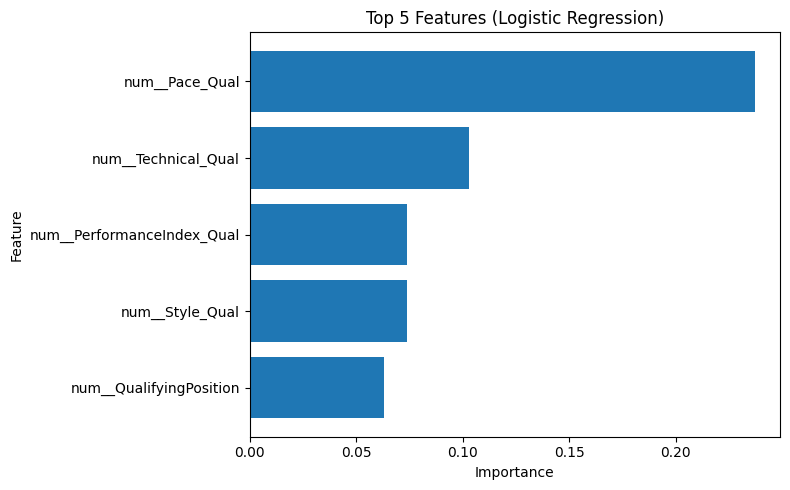

In [61]:

import matplotlib.pyplot as plt
import pandas as pd
import re

# Parse "feature (importance)" pairs from the result string
feature_str = result["Top 10 Features"]

if isinstance(feature_str, str) and feature_str != "N/A":
    # Use regex to extract (feature, importance)
    pattern = r"([\w\-]+)\s*\(([-+]?\d*\.\d+|\d+)\)"
    parsed = re.findall(pattern, feature_str)

    if parsed:
        top_features_df = pd.DataFrame(parsed, columns=["Feature", "Importance"])
        top_features_df["Importance"] = top_features_df["Importance"].astype(float)

        # Select top 5
        top5 = top_features_df.head(5)

        # Plot
        plt.figure(figsize=(8, 5))
        plt.barh(top5["Feature"], top5["Importance"])
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.title("Top 5 Features (Logistic Regression)")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ Could not parse feature importance string.")
else:
    print("⚠️ No feature importance data available.")


MERGING DATA FOR PLOTTING

In [63]:
data_raw.head()

,Timestamp,driver_code,Consistency_Race,Style_Race,Technical_Race,Pace_Race,PerformanceIndex_Race,Consistency_Qual,Style_Qual,Technical_Qual,...,Finish_pct,Accident_pct,Collision_pct,Damage Related_pct,DNF_pct,Race_Complexity_Score,Safety_Index,mechanical_faults,avg_stops_per_car_race,avg_pitstop_ms
0,11/11/2025 20:10,HAM,0.487,0.870,0.308,0.885,0.637,0.254,0.203,0.403,...,84.416,3.896,11.688,0.000,15.584,0.492,0.352,0.000,1.892,160011.280
1,11/11/2025 20:10,LEC,0.500,0.204,0.574,0.500,0.444,0.000,0.200,0.305,...,84.416,3.896,11.688,0.000,15.584,0.492,0.352,0.000,1.892,160011.280
2,11/11/2025 20:10,NOR,0.664,0.549,0.326,1.000,0.635,0.169,0.500,0.417,...,84.416,3.896,11.688,0.000,15.584,0.492,0.352,0.000,1.892,160011.280
3,11/11/2025 20:10,PIA,0.459,0.382,0.709,0.962,0.628,0.341,0.203,0.190,...,84.416,3.896,11.688,0.000,15.584,0.492,0.352,0.000,1.892,160011.280
4,11/11/2025 20:10,RUS,0.480,0.532,0.403,0.654,0.517,0.464,0.792,0.232,...,84.416,3.896,11.688,0.000,15.584,0.492,0.352,0.000,1.892,160011.280


In [64]:
test_results.head()

,cat__team_Alpine Renault,cat__team_Aston Martin Aramco Mercedes,cat__team_Ferrari,cat__team_McLaren,cat__team_McLaren Mercedes,cat__team_McLaren Renault,cat__team_Mercedes,cat__team_Red Bull Racing,cat__team_Red Bull Racing Honda,cat__team_Red Bull Racing Honda RBPT,...,num__Damage Related_pct,num__DNF_pct,num__Race_Complexity_Score,num__Safety_Index,num__mechanical_faults,num__avg_stops_per_car_race,num__avg_pitstop_ms,Actual,Predicted,Predicted_Prob
73,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,13.725,0.415,0.448,0.000,1.892,160011.280,0,0,0.638
19,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,5.882,0.278,0.664,0.000,1.892,160011.280,0,0,0.984
116,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,...,0.000,14.400,0.478,0.378,0.000,1.892,160011.280,1,1,0.715
67,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,...,0.000,11.458,0.369,0.516,0.000,1.892,160011.280,0,0,0.881
94,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,12.621,0.392,0.481,0.000,1.892,160011.280,2,2,0.522


In [65]:
test_results = test_results.rename(columns={
    'num__PerformanceIndex_Qual': 'PerformanceIndex_Qual',
    # 'race_name': 'GrandPrix',
    # 'season': 'Year'
})

final_results = pd.merge(
    test_results,
    data_raw[['PerformanceIndex_Qual','driver_code', 'GrandPrix', 'year','team',"RaceFinishPosition"]],  # keep only relevant keys
    on=['PerformanceIndex_Qual'],
    how='left'   # keeps all rows from test_results
)


final_results.head()


,cat__team_Alpine Renault,cat__team_Aston Martin Aramco Mercedes,cat__team_Ferrari,cat__team_McLaren,cat__team_McLaren Mercedes,cat__team_McLaren Renault,cat__team_Mercedes,cat__team_Red Bull Racing,cat__team_Red Bull Racing Honda,cat__team_Red Bull Racing Honda RBPT,...,num__avg_stops_per_car_race,num__avg_pitstop_ms,Actual,Predicted,Predicted_Prob,driver_code,GrandPrix,year,team,RaceFinishPosition
0,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,...,1.892,160011.280,0,0,0.638,PIA,Canadian Grand Prix,2025,McLaren,4.000
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,1.892,160011.280,0,0,0.984,SAI,Chinese Grand Prix,2025,Williams,10.000
2,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,...,1.892,160011.280,1,1,0.715,RUS,Singapore Grand Prix,2025,Mercedes,1.000
3,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,...,1.892,160011.280,0,0,0.881,RUS,Spanish Grand Prix,2025,Mercedes,4.000
4,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,...,1.892,160011.280,2,2,0.522,PIA,Hungarian Grand Prix,2025,McLaren,2.000


PLOTTING Test Results

In [85]:
data_results=pd.read_csv(r"C:\Enzo_Files\AIM Data Science\AIM_Sharing\ML1_Final_Project\F1_Model_Results_v2.csv")
data_results=pd.read_csv(r"C:\Enzo_Files\AIM Data Science\AIM_Sharing\ML1_Final_Project\F1_Model_Results_v3.csv")

# data_results_v2 = final_results.copy()
data_results.columns

Index(['cat__team_Alpine Renault', 'cat__team_Aston Martin Aramco Mercedes',
       'cat__team_Ferrari', 'cat__team_McLaren', 'cat__team_McLaren Mercedes',
       'cat__team_McLaren Renault', 'cat__team_Mercedes',
       'cat__team_Red Bull Racing', 'cat__team_Red Bull Racing Honda',
       'cat__team_Red Bull Racing Honda RBPT',
       'cat__team_Red Bull Racing RBPT', 'cat__team_Renault',
       'cat__team_Williams', 'cat__team_Williams Mercedes',
       'cat__team_infrequent_sklearn', 'cat__Direction_Anti-clockwise',
       'cat__Direction_Clockwise', 'num__Consistency_Qual', 'num__Style_Qual',
       'num__Technical_Qual', 'num__Pace_Qual', 'PerformanceIndex_Qual',
       'num__Round', 'num__year', 'num__QualifyingPosition', 'num__Laps',
       'num__Corners', 'num__Circuit length (km)', 'num__Race distance (km)',
       'num__Accident', 'num__Collision', 'num__Damage Related', 'num__Finish',
       'num__Total_Entries', 'num__Finish_pct', 'num__Accident_pct',
       'num__Collisio

In [86]:
data_results_2 = data_results[[
    'PerformanceIndex_Qual',
    'num__Round',
    'num__year',
    'num__QualifyingPosition',
    # 'num__driver_points',
    # 'num__team_points',
    'num__Finish_pct',
    'num__Accident_pct',
    'num__Collision_pct',
    'num__Race_Complexity_Score',
    'num__Safety_Index',
    'Actual',
    'Predicted',
    'Predicted_Prob',
    'driver_code',
    'GrandPrix',
    'year',
    'team',
    'RaceFinishPosition'
]]

data_results_2.head()


,PerformanceIndex_Qual,num__Round,num__year,num__QualifyingPosition,num__Finish_pct,num__Accident_pct,num__Collision_pct,num__Race_Complexity_Score,num__Safety_Index,Actual,Predicted,Predicted_Prob,driver_code,GrandPrix,year,team,RaceFinishPosition
0,0.541,10.000,2025.000,3.000,86.275,2.941,10.784,0.415,0.448,0,0,0.638,PIA,Canadian Grand Prix,2025,McLaren,4.000
1,0.525,2.000,2025.000,15.000,94.118,1.176,4.706,0.278,0.664,0,0,0.984,SAI,Chinese Grand Prix,2025,Williams,10.000
2,0.840,18.000,2025.000,1.000,85.600,6.400,8.000,0.478,0.378,1,1,0.715,RUS,Singapore Grand Prix,2025,Mercedes,1.000
3,0.579,9.000,2025.000,4.000,88.542,1.042,10.417,0.369,0.516,0,0,0.881,RUS,Spanish Grand Prix,2025,Mercedes,4.000
4,0.663,14.000,2025.000,2.000,87.379,3.883,8.738,0.392,0.481,2,2,0.522,PIA,Hungarian Grand Prix,2025,McLaren,2.000


In [88]:
import plotly.graph_objects as go
import numpy as np

# Sort data for chronological order
data_results_2 = data_results_2.sort_values(by='num__Round')

# Add a boolean column for correct predictions
data_results_2['Correct'] = np.where(
    data_results_2['Actual'] == data_results_2['Predicted'], 1, 0
)

# Map colors: green = correct, red = wrong
data_results_2['Color'] = np.where(
    data_results_2['Correct'] == 1, "#18e341", 'red'
)

# Get list of unique drivers
drivers = data_results_2['driver_code'].unique()

# Create figure
fig = go.Figure()

# Add one trace per driver
for driver in drivers:
    driver_data = data_results_2[data_results_2['driver_code'] == driver]
    fig.add_trace(go.Scatter(
        x=driver_data['GrandPrix'],
        y=driver_data['RaceFinishPosition'],
        mode='markers+lines',
        name=driver,
        text=driver_data['RaceFinishPosition'],
        textposition='top center',
        marker=dict(
            size=15,
            color=driver_data['Color'],      # red/green based on correctness
            line=dict(width=1, color='black')
        ),
        hovertemplate=(
            "<b>%{x}</b><br>"
            "Driver: <b>%{customdata[0]}</b><br>"
            "Team: %{customdata[1]}<br>"
            "Round: %{customdata[2]}<br>"
            "Finish: %{y}<br>"
            "Predicted: %{customdata[3]:.3f}<br>"
            "Actual: %{customdata[4]:.3f}<br>"
            "<b>Correct:</b> %{customdata[5]}<br>"
            "Prob: %{customdata[6]:.3f}<extra></extra>"
        ),
        customdata=np.stack([
            driver_data['driver_code'],
            driver_data['team'],
            driver_data['num__Round'],
            driver_data['Predicted'],
            driver_data['Actual'],
            np.where(driver_data['Correct'] == 1, '✅ Yes', '❌ No'),
            driver_data['Predicted_Prob']
        ], axis=-1)
    ))

# Reverse Y-axis so P1 is on top
fig.update_yaxes(
    autorange='reversed',
    title_text='Race Finish Position'
)

# Set Grand Prix labels on X-axis
fig.update_xaxes(
    title_text='Grand Prix',
    tickangle=45,
    tickmode='array',
    tickvals=data_results_2['GrandPrix'].unique()
)

# Add Podium line (P3)
fig.add_shape(
    type='line',
    x0=-0.5,
    x1=len(data_results_2['GrandPrix'].unique()) - 0.5,
    y0=3,
    y1=3,
    line=dict(color='red', width=3, dash='dash'),
    xref='x',
    yref='y'
)

# Layout styling
fig.update_layout(
    title='🏁 Race Finish Position by Grand Prix (Colored by Prediction Accuracy)',
    template='plotly_white',
    hovermode='closest',
    legend_title_text='Driver',
    title_x=0.5,
    height=700,
)

fig.write_html("F1_Main_graph.html")
fig.show()



COMPARING with Benchmark

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt

data_check = data_results_2

# PREDICTION USING QUALIFYING POSITION: 1st, 2nd, 3rd and No Podium ============================
qp = data_check["num__QualifyingPosition"]
data_check["Qual_prediction"] = qp.where(qp <= 3, 0).astype(int)

# --- Set up y_true and predictions (multi-class) ---
y_true = pd.to_numeric(data_check["Actual"], errors="coerce").astype(int)

# Model prediction (if probs, convert to class; if already labels, just cast to int)
pred_raw = data_check["Predicted"]
y_model = (pd.to_numeric(pred_raw, errors="coerce").astype(int))

y_rule = pd.to_numeric(data_check["Qual_prediction"], errors="coerce").astype(int)

# Classes present in any of the series
labels = np.sort(np.unique(np.concatenate([y_true.values, y_model.values, y_rule.values])))

# Confusion matrices
cm_model = confusion_matrix(y_true, y_model, labels=labels)
cm_rule  = confusion_matrix(y_true, y_rule,  labels=labels)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ConfusionMatrixDisplay(cm_model, display_labels=labels).plot(ax=axes[0], colorbar=False)
axes[0].set_title("Model Predicted vs Actual")
ConfusionMatrixDisplay(cm_rule, display_labels=labels).plot(ax=axes[1], colorbar=False)
axes[1].set_title("Rule Qual_prediction vs Actual")
plt.tight_layout()
plt.show()

# Summary metrics (weighted for multi-class)
summary = pd.DataFrame({
    "accuracy":  [accuracy_score(y_true, y_model), accuracy_score(y_true, y_rule)],
    "precision": [precision_score(y_true, y_model, average="weighted", zero_division=0),
                  precision_score(y_true, y_rule,  average="weighted", zero_division=0)],
    "recall":    [recall_score(y_true, y_model, average="weighted", zero_division=0),
                  recall_score(y_true, y_rule,  average="weighted", zero_division=0)],
    "f1":        [f1_score(y_true, y_model, average="weighted", zero_division=0),
                  f1_score(y_true, y_rule,  average="weighted", zero_division=0)],
}, index=["Model", "Rule"])

print(summary)


,PerformanceIndex_Qual,num__Round,num__year,num__QualifyingPosition,num__Finish_pct,num__Accident_pct,num__Collision_pct,num__Race_Complexity_Score,num__Safety_Index,Actual,Predicted,Predicted_Prob,driver_code,GrandPrix,year,team,RaceFinishPosition,Correct,Color,Qual_prediction
1,0.525,2.000,2025.000,15.000,94.118,1.176,4.706,0.278,0.664,0,0,0.984,SAI,Chinese Grand Prix,2025,Williams,10.000,1,#18e341,0
15,0.578,2.000,2025.000,2.000,94.118,1.176,4.706,0.278,0.664,3,0,0.434,RUS,Chinese Grand Prix,2025,Mercedes,3.000,0,red,2
59,0.328,2.000,2025.000,3.000,94.118,1.176,4.706,0.278,0.664,2,0,0.634,NOR,Chinese Grand Prix,2025,McLaren,2.000,0,red,3
35,0.462,2.000,2025.000,6.000,94.118,1.176,4.706,0.278,0.664,0,0,0.972,LEC,Chinese Grand Prix,2025,Ferrari,18.000,1,#18e341,0
122,0.818,2.000,2025.000,4.000,94.118,1.176,4.706,0.278,0.664,0,0,0.569,VER,Chinese Grand Prix,2025,Red Bull Racing,4.000,1,#18e341,0


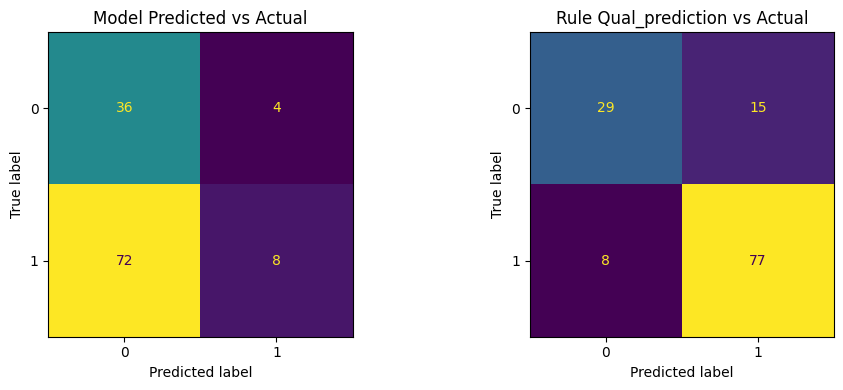

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [94]:

# If needed: ensure binary ints (adjust mapping as appropriate)
y_true = pd.to_numeric(data_check["Correct"], errors="coerce").astype(int)

# If Predicted is probabilities, threshold at 0.5; otherwise cast to int
pred_raw = data_check["Predicted"]
y_pred = ((pred_raw >= 0.5).astype(int)
          if np.issubdtype(pred_raw.dtype, np.number) and not np.issubdtype(pred_raw.dtype, np.integer)
          else pd.to_numeric(pred_raw, errors="coerce").astype(int))

y_rule = pd.to_numeric(data_check["Qual_prediction"], errors="coerce").astype(int)

# Confusion matrices
cm_model = confusion_matrix(y_true, y_pred, labels=[0, 1])
cm_rule  = confusion_matrix(y_true, y_rule, labels=[0, 1])

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ConfusionMatrixDisplay(cm_model, display_labels=[0,1]).plot(ax=axes[0], colorbar=False)
axes[0].set_title("Model Predicted vs Actual")
ConfusionMatrixDisplay(cm_rule, display_labels=[0,1]).plot(ax=axes[1], colorbar=False)
axes[1].set_title("Rule Qual_prediction vs Actual")
plt.tight_layout()
plt.show()

# Summary metrics
summary = pd.DataFrame({
    "accuracy":  [accuracy_score(y_true, y_pred), accuracy_score(y_true, y_rule)],
    "precision": [precision_score(y_true, y_pred, zero_division=0), precision_score(y_true, y_rule, zero_division=0)],
    "recall":    [recall_score(y_true, y_pred, zero_division=0), recall_score(y_true, y_rule, zero_division=0)],
    "f1":        [f1_score(y_true, y_pred, zero_division=0), f1_score(y_true, y_rule, zero_division=0)],
}, index=["Model", "Rule"])
print(summary)





In [ ]:
          if np.issubdtype(pred_raw.dtype, np.number) and not np.issubdtype(pred_raw.dtype, np.integer)
          else pd.to_numeric(pred_raw, errors="coerce").astype(int))

y_rule = pd.to_numeric(data_check["Qual_prediction"], errors="coerce").astype(int)

# Confusion matrices
cm_model = confusion_matrix(y_true, y_pred, labels=[0, 1])
cm_rule  = confusion_matrix(y_true, y_rule, labels=[0, 1])

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ConfusionMatrixDisplay(cm_model, display_labels=[0,1]).plot(ax=axes[0], colorbar=False)
axes[0].set_title("Model Predicted vs Actual")
ConfusionMatrixDisplay(cm_rule, display_labels=[0,1]).plot(ax=axes[1], colorbar=False)
axes[1].set_title("Rule Qual_prediction vs Actual")
plt.tight_layout()
plt.show()

# Summary metrics
summary = pd.DataFrame({
    "accuracy":  [accuracy_score(y_true, y_pred), accuracy_score(y_true, y_rule)],
    "precision": [precision_score(y_true, y_pred, zero_division=0), precision_score(y_true, y_rule, zero_division=0)],
    "recall":    [recall_score(y_true, y_pred, zero_division=0), recall_score(y_true, y_rule, zero_division=0)],
    "f1":        [f1_score(y_true, y_pred, zero_division=0), f1_score(y_true, y_rule, zero_division=0)],
}, index=["Model", "Rule"])
print(summary)





In [80]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt

data_check = data_results_2

# ================================
# 1) BUILD BOTH RULE-BASED PREDICTORS
# ================================

qp = data_check["num__QualifyingPosition"]

# Binary rule: podium (1) vs no podium (0)
data_check["Rule_binary"] = (qp <= 3).astype(int)

# Four-class rule: 1,2,3 -> same label; else 0
data_check["Rule_multiclass"] = qp.where(qp <= 3, 0).astype(int)
data_check


,PerformanceIndex_Qual,num__Round,num__year,num__QualifyingPosition,num__Finish_pct,num__Accident_pct,num__Collision_pct,num__Race_Complexity_Score,num__Safety_Index,Actual,...,driver_code,GrandPrix,year,team,RaceFinishPosition,Correct,Color,Qual_prediction,Rule_binary,Rule_multiclass
1,0.525,2.000,2025.000,15.000,94.118,1.176,4.706,0.278,0.664,0,...,SAI,Chinese Grand Prix,2025,Williams,10.000,1,#18e341,0,0,0
15,0.578,2.000,2025.000,2.000,94.118,1.176,4.706,0.278,0.664,3,...,RUS,Chinese Grand Prix,2025,Mercedes,3.000,0,red,2,1,2
59,0.328,2.000,2025.000,3.000,94.118,1.176,4.706,0.278,0.664,2,...,NOR,Chinese Grand Prix,2025,McLaren,2.000,0,red,3,1,3
35,0.462,2.000,2025.000,6.000,94.118,1.176,4.706,0.278,0.664,0,...,LEC,Chinese Grand Prix,2025,Ferrari,18.000,1,#18e341,0,0,0
122,0.818,2.000,2025.000,4.000,94.118,1.176,4.706,0.278,0.664,0,...,VER,Chinese Grand Prix,2025,Red Bull Racing,4.000,1,#18e341,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,0.407,19.000,2025.000,6.000,86.842,3.509,8.772,0.463,0.405,0,...,PIA,United States Grand Prix,2025,McLaren,5.000,1,#18e341,0,0,0
64,0.600,19.000,2025.000,5.000,86.842,3.509,8.772,0.463,0.405,0,...,HAM,United States Grand Prix,2025,Ferrari,4.000,1,#18e341,0,0,0
68,0.507,19.000,2025.000,2.000,86.842,3.509,8.772,0.463,0.405,2,...,NOR,United States Grand Prix,2025,McLaren,2.000,0,red,2,1,2
34,0.702,19.000,2025.000,4.000,86.842,3.509,8.772,0.463,0.405,0,...,RUS,United States Grand Prix,2025,Mercedes,6.000,1,#18e341,0,0,0


In [ ]:

# ===================================
# 2) TRUE LABELS AND MODEL PREDICTIONS
# ===================================

y_true = pd.to_numeric(data_check["Actual"], errors="coerce").astype(int)

pred_raw = data_check["Predicted"]
y_pred = (
    (pred_raw >= 0.5).astype(int)
    if np.issubdtype(pred_raw.dtype, np.number) and 
       not np.issubdtype(pred_raw.dtype, np.integer)
    else pd.to_numeric(pred_raw, errors="coerce").astype(int)
)

y_rule_bin  = pd.to_numeric(data_check["Rule_binary"], errors="coerce").astype(int)
y_rule_multi = pd.to_numeric(data_check["Rule_multiclass"], errors="coerce").astype(int)

# ===================================
# 3) CONFUSION MATRICES (BINARY ONLY)
# ===================================
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Model
cm_model = confusion_matrix(y_true, y_pred, labels=[0, 1])
ConfusionMatrixDisplay(cm_model, display_labels=[0,1]).plot(ax=axes[0], colorbar=False)
axes[0].set_title("Model vs Actual")

# Binary Rule
cm_bin = confusion_matrix(y_true, y_rule_bin, labels=[0, 1])
ConfusionMatrixDisplay(cm_bin, display_labels=[0,1]).plot(ax=axes[1], colorbar=False)
axes[1].set_title("Binary Rule vs Actual")

# Multiclass Rule (converted to binary for visualization)
cm_multi = confusion_matrix(y_true, (y_rule_multi > 0).astype(int), labels=[0, 1])
ConfusionMatrixDisplay(cm_multi, display_labels=[0,1]).plot(ax=axes[2], colorbar=False)
axes[2].set_title("Multiclass Rule (binarized) vs Actual")

plt.tight_layout()
plt.show()

# ===================================
# 4) SUMMARY METRICS (BINARY)
# ===================================
# Convert actual results to binary podium vs not-podium
y_true_binary = (y_true > 0).astype(int)

summary = pd.DataFrame({
    "accuracy":  [
        accuracy_score(y_true_binary, y_pred),
        accuracy_score(y_true_binary, y_rule_bin),
        accuracy_score(y_true_binary, (y_rule_multi > 0).astype(int))
    ],
    # "precision": [
    #     precision_score(y_true_binary, y_pred, zero_division=0),
    #     precision_score(y_true_binary, y_rule_bin, zero_division=0),
    #     precision_score(y_true_binary, (y_rule_multi > 0).astype(int), zero_division=0)
    # ],
    # "recall": [
    #     recall_score(y_true_binary, y_pred, zero_division=0),
    #     recall_score(y_true_binary, y_rule_bin, zero_division=0),
    #     recall_score(y_true_binary, (y_rule_multi > 0).astype(int), zero_division=0)
    # ],
    # "f1": [
    #     f1_score(y_true_binary, y_pred, zero_division=0),
    #     f1_score(y_true_binary, y_rule_bin, zero_division=0),
    #     f1_score(y_true_binary, (y_rule_multi > 0).astype(int), zero_division=0)
    # ]
}, index=["Model", "Binary Rule", "Multiclass Rule→Binary"])

print(summary)


In [78]:
data_check

,PerformanceIndex_Qual,num__Round,num__year,num__QualifyingPosition,num__Finish_pct,num__Accident_pct,num__Collision_pct,num__Race_Complexity_Score,num__Safety_Index,Actual,...,driver_code,GrandPrix,year,team,RaceFinishPosition,Correct,Color,Qual_prediction,Rule_binary,Rule_multiclass
1,0.525,2.000,2025.000,15.000,94.118,1.176,4.706,0.278,0.664,0,...,SAI,Chinese Grand Prix,2025,Williams,10.000,1,#18e341,0,0,0
15,0.578,2.000,2025.000,2.000,94.118,1.176,4.706,0.278,0.664,3,...,RUS,Chinese Grand Prix,2025,Mercedes,3.000,0,red,2,1,2
59,0.328,2.000,2025.000,3.000,94.118,1.176,4.706,0.278,0.664,2,...,NOR,Chinese Grand Prix,2025,McLaren,2.000,0,red,3,1,3
35,0.462,2.000,2025.000,6.000,94.118,1.176,4.706,0.278,0.664,0,...,LEC,Chinese Grand Prix,2025,Ferrari,18.000,1,#18e341,0,0,0
122,0.818,2.000,2025.000,4.000,94.118,1.176,4.706,0.278,0.664,0,...,VER,Chinese Grand Prix,2025,Red Bull Racing,4.000,1,#18e341,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,0.407,19.000,2025.000,6.000,86.842,3.509,8.772,0.463,0.405,0,...,PIA,United States Grand Prix,2025,McLaren,5.000,1,#18e341,0,0,0
64,0.600,19.000,2025.000,5.000,86.842,3.509,8.772,0.463,0.405,0,...,HAM,United States Grand Prix,2025,Ferrari,4.000,1,#18e341,0,0,0
68,0.507,19.000,2025.000,2.000,86.842,3.509,8.772,0.463,0.405,2,...,NOR,United States Grand Prix,2025,McLaren,2.000,0,red,2,1,2
34,0.702,19.000,2025.000,4.000,86.842,3.509,8.772,0.463,0.405,0,...,RUS,United States Grand Prix,2025,Mercedes,6.000,1,#18e341,0,0,0


Comparing with benchmark

In [ ]:
data_results_v2=pd.read_csv(r"C:\Enzo_Files\AIM Data Science\AIM_Sharing\ML1_Final_Project\F1_Model_Results_v2.csv")
data_results_v2
